# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 30

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 128

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
595   HAM_0004288            ISIC_0026445.jpg     nv      histo  35.0    male  \
3963  HAM_0002914  aug_HRlWbKISIC_0024904.jpg   vasc      histo  75.0    male   
1359  HAM_0005674            ISIC_0031060.jpg    bkl      histo  70.0  female   
2475  HAM_0005381            ISIC_0031598.jpg    mel      histo  45.0  female   
883   HAM_0000113            ISIC_0029548.jpg    bkl      histo  75.0  female   
4149  HAM_0004542  aug_uIyOhgISIC_0027256.jpg   vasc  consensus   0.0  female   
2248  HAM_0004992  aug_aHNok4ISIC_0026132.jpg  akiec      histo  70.0    male   
4173  HAM_0003829  aug_jTbeSYISIC_0026349.jpg   vasc  consensus  60.0  female   
4695  HAM_0007225  aug_AjnDdIISIC_0032247.jpg     df      histo  75.0    male   
455   HAM_0002500            ISIC_0028169.jpg     nv  follow_up  45.0    male   
4339  HAM_0002610  aug_RiDFzWISIC_0030606.jpg   vasc  consensus   0.0  female   
1665  HAM_0006434            ISIC_0028076.jpg  akiec      histo  60.0    male   
1628  HAM_0005551            ISIC_0029900.jpg  akiec      histo  60.0    male   
496   HAM_0006334            ISIC_0032605.jpg     nv      histo  40.0  female   
2382  HAM_0000241            ISIC_0030932.jpg    mel      histo  70.0  female   

         localization        dataset        dx_binary     dx_tertiary   
595             chest      rosendahl  not_skin_cancer          benign  \
3963  upper extremity   vidir_modern  not_skin_cancer  non-neoplastic   
1359             back      rosendahl  not_skin_cancer  non-neoplastic   
2475  lower extremity   vidir_modern      skin_cancer       malignant   
883              hand    vienna_dias  not_skin_cancer  non-neoplastic   
4149             back   vidir_modern  not_skin_cancer  non-neoplastic   
2248            chest      rosendahl      skin_cancer       malignant   
4173            trunk  vidir_molemax  not_skin_cancer  non-neoplastic   
4695  lower extremity    vienna_dias  not_skin_cancer  non-neoplastic   
455              back  vidir_molemax  not_skin_cancer          benign   
4339          abdomen   vidir_modern  not_skin_cancer  non-neoplastic   
1665  lower extremity      rosendahl      skin_cancer       malignant   
1628             face      rosendahl      skin_cancer       malignant   
496              back   vidir_modern  not_skin_cancer          benign   
2382  lower extremity      rosendahl      skin_cancer       malignant   

                                     image_path  
595             ./../data/jpgs/ISIC_0026445.jpg  
3963  ./../data/jpgs/aug_HRlWbKISIC_0024904.jpg  
1359            ./../data/jpgs/ISIC_0031060.jpg  
2475            ./../data/jpgs/ISIC_0031598.jpg  
883             ./../data/jpgs/ISIC_0029548.jpg  
4149  ./../data/jpgs/aug_uIyOhgISIC_0027256.jpg  
2248  ./../data/jpgs/aug_aHNok4ISIC_0026132.jpg  
4173  ./../data/jpgs/aug_jTbeSYISIC_0026349.jpg  
4695  ./../data/jpgs/aug_AjnDdIISIC_0032247.jpg  
455             ./../data/jpgs/ISIC_0028169.jpg  
4339  ./../data/jpgs/aug_RiDFzWISIC_0030606.jpg  
1665            ./../data/jpgs/ISIC_0028076.jpg  
1628            ./../data/jpgs/ISIC_0029900.jpg  
496             ./../data/jpgs/ISIC_0032605.jpg  
2382            ./../data/jpgs/ISIC_0030932.jpg

## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [3]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

Here we can add extra augmentation filters in the ImageDataGenerator to increase the number of images in the training set. This is done to avoid overfitting and to increase the generalization of the model.

In [4]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.15,             # Randomly zoom in and out by up to 15%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest',         # Strategy for filling in newly created pixels after transformations
    brightness_range=(0.7, 1.2), # Randomly change the brightness of images (between 70% and 120% of original value) NEW
    channel_shift_range=5,       # Randomly change the intensity of color channels (between -5 and 5) NEW
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


### Control: Show some images from the train data set after preprocessing

In [5]:
# function to show some images from the generator as control of correct input
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [6]:
images, labels = next(train_data_generator) # get a batch of images and labels
print(images.min(), images.max(), images.dtype) # print the min, max and dtype

0.0 1.0 float32


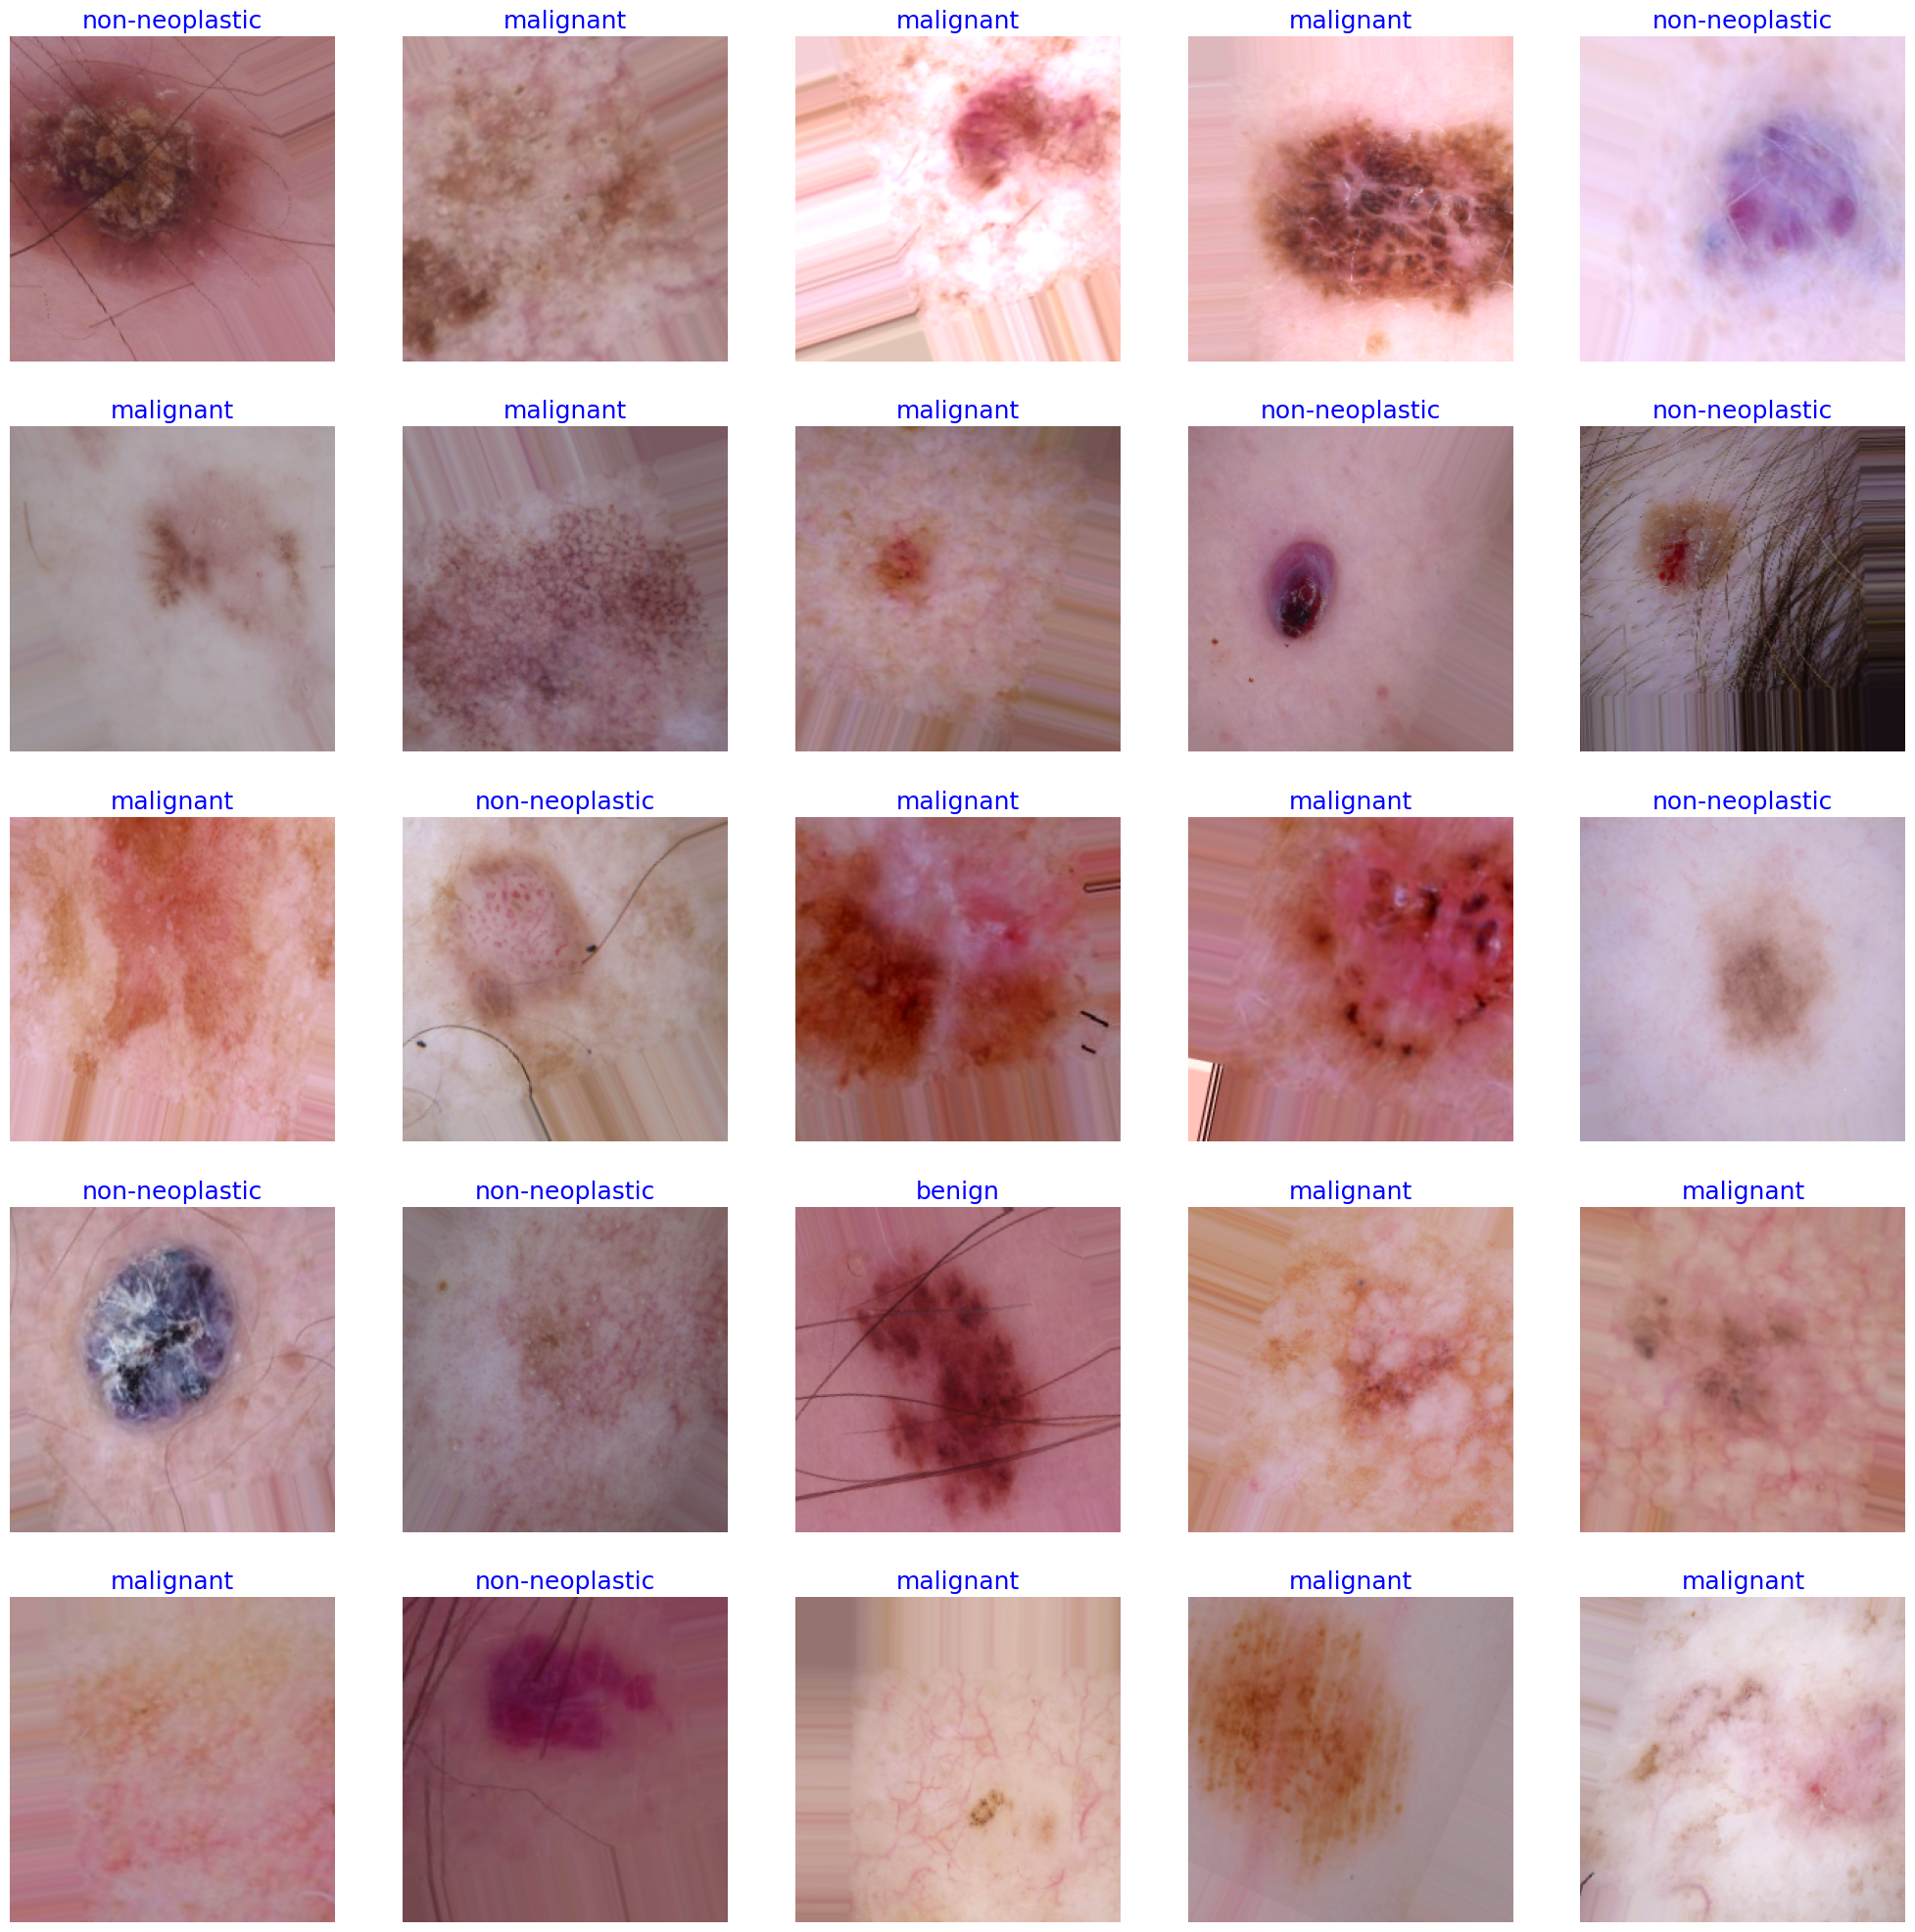

In [7]:
# show images from the generator
show_image_samples(train_data_generator)

## ResNet50


### Functions for the model

#### F1 score metric function for model compilation

In [8]:
# function for f1 score integrated in the model
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # true positives + false positives
    recall = true_positives / (possible_positives + K.epsilon()) # recall = true positives / (true positives + false negatives) 

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    precision = true_positives / (predicted_positives + K.epsilon()) # precision = true positives / (true positives + false positives)

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon())) # F1 score = 2 * (precision * recall) / (precision + recall)

#### focal loss function for model compilation (not yet in use)

In [9]:
# currently not in use, could be worth a try
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

### Model architecture

In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x) 
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
x = Dropout(0.2)(x) # Dropout layer to reduce overfitting
x= Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name='Resnet50_tert_brightness_channelshift_dropout02_adam_lr_scheduler')

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer1 = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_score])

# Print model summary
model.summary()

Model: "Resnet50_tert_brightness_channelshift_dropout02_adam_lr_scheduler"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                              

### Callback functions

In [11]:
# This is currently not in use, could be worth a try
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)

#### Learning rate scheduler for model compilation

In [12]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 4  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

#### Class weights 

In [13]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

#### Early stopping

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=10,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

## Model Training

In [15]:
# Train the model
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=NUM_EPOCHS,  # Number of training epochs
    verbose=1,  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,  # Batch size for training
    callbacks=[lr_scheduler],  # List of callbacks to apply during training
    validation_split=0.0,  # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,  # Shuffle the training data before each epoch
    sample_weight=None,  # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,  # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,  # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,  # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,  # Frequency to validate the model on the validation set
    max_queue_size=10,  # Maximum size of the generator queue
    workers=-1,  # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False  # Use multiprocessing for data generation (True or False)
)

Epoch 1/30
42/42 [==============================] - 1293s 31s/step - loss: 0.7044 - accuracy: 0.6633 - f1_score: 0.6534 - val_loss: 1.1852 - val_accuracy: 0.1359 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
42/42 [==============================] - 1309s 31s/step - loss: 0.4763 - accuracy: 0.7712 - f1_score: 0.7688 - val_loss: 1.3652 - val_accuracy: 0.1359 - val_f1_score: 0.1345 - lr: 1.0000e-04
Epoch 3/30
42/42 [==============================] - 1297s 31s/step - loss: 0.3969 - accuracy: 0.8175 - f1_score: 0.8211 - val_loss: 2.2142 - val_accuracy: 0.1359 - val_f1_score: 0.1369 - lr: 1.0000e-04
Epoch 4/30
42/42 [==============================] - 1326s 32s/step - loss: 0.3244 - accuracy: 0.8519 - f1_score: 0.8475 - val_loss: 2.1776 - val_accuracy: 0.1359 - val_f1_score: 0.1358 - lr: 5.0000e-05
Epoch 5/30
42/42 [==============================] - 1315s 31s/step - loss: 0.2774 - accuracy: 0.8732 - f1_score: 0.8733 - val_loss: 2.8170 - val_accuracy: 0.1359 - val_f1_score: 0.1358 - l

## Evaluation on Train and Validation data


#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

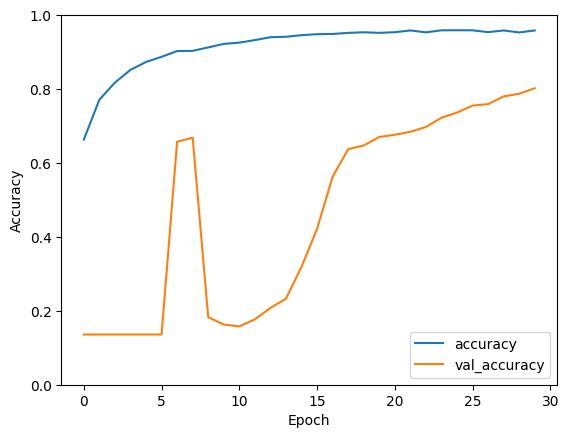

In [16]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

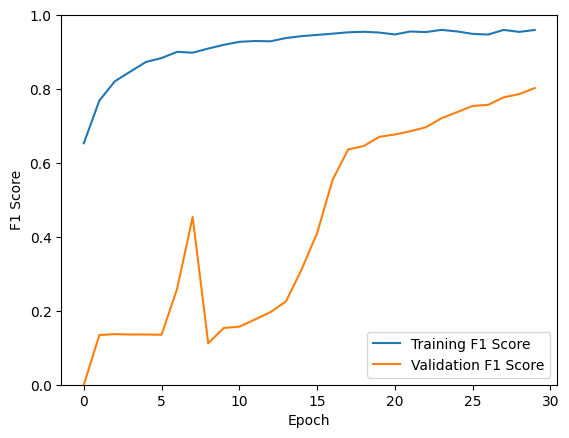

In [17]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

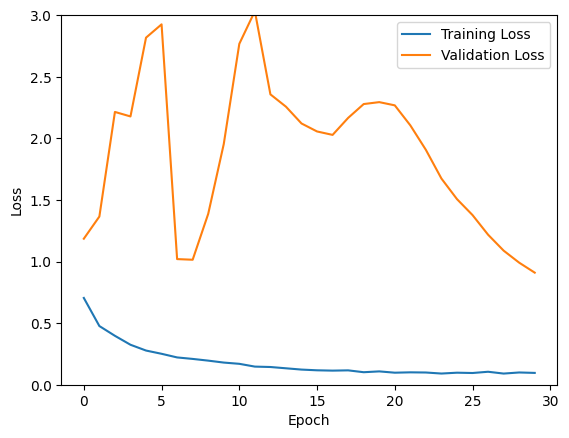

In [18]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluation on test set

#### Calculation AUC, Confusion Matrix, Classification Report

 > Evaluating model Resnet50_tert_brightness_channelshift_dropout02_adam_lr_scheduler:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 45s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.9247638181633268
 > Micro AUC: 0.9347465249142434


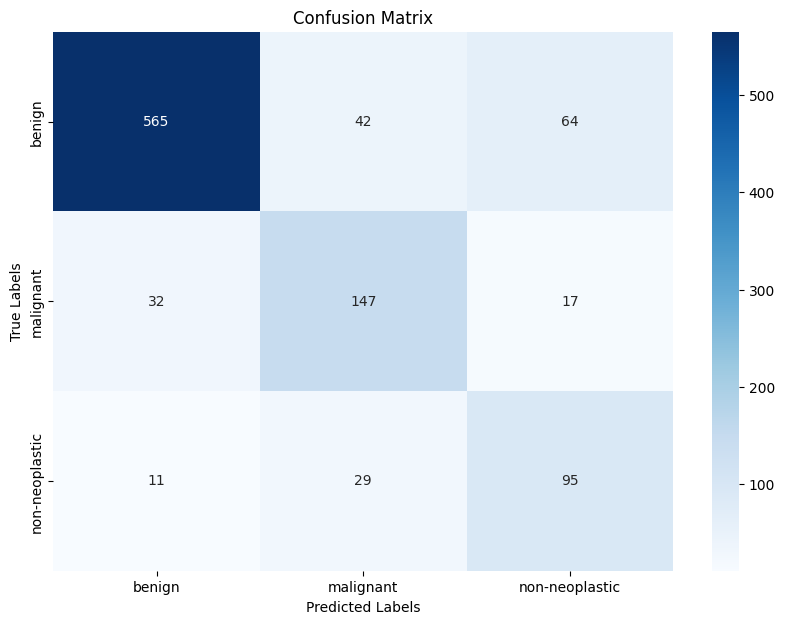



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       671
           1       0.67      0.75      0.71       196
           2       0.54      0.70      0.61       135

    accuracy                           0.81      1002
   macro avg       0.71      0.77      0.73      1002
weighted avg       0.83      0.81      0.81      1002

 > Evaluating model on test set...
32/32 [==============================] - 45s 1s/step - loss: 0.9180 - accuracy: 0.8054 - f1_score: 0.8028
loss: 0.9179559946060181
accuracy: 0.8053892254829407
f1_score: 0.8027902245521545
 > Done.


([{'loss': 0.9179559946060181},
  {'accuracy': 0.8053892254829407},
  {'f1_score': 0.8027902245521545}],
 array([[565,  42,  64],
        [ 32, 147,  17],
        [ 11,  29,  95]]),
 (0.9347465249142434, 0.9247638181633268))

In [19]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [20]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Continue training

In [22]:
# Continue training for another 10 epochs
additional_epochs = 10
continue_training = True

if continue_training:
    history_continued = model.fit(
        train_data_generator,
        steps_per_epoch=None,
        epochs=NUM_EPOCHS + additional_epochs,
        initial_epoch=NUM_EPOCHS,  # start from the epoch after your last training session
        validation_data=validation_generator)


Epoch 31/40
42/42 [==============================] - 1478s 35s/step - loss: 0.1023 - accuracy: 0.9602 - f1_score: 0.9613 - val_loss: 0.9011 - val_accuracy: 0.7892 - val_f1_score: 0.7926
Epoch 32/40
42/42 [==============================] - 1424s 34s/step - loss: 0.0980 - accuracy: 0.9619 - f1_score: 0.9626 - val_loss: 0.9151 - val_accuracy: 0.7862 - val_f1_score: 0.7870
Epoch 33/40
42/42 [==============================] - 1445s 34s/step - loss: 0.0918 - accuracy: 0.9617 - f1_score: 0.9630 - val_loss: 0.9285 - val_accuracy: 0.7892 - val_f1_score: 0.7909
Epoch 34/40
42/42 [==============================] - 1358s 32s/step - loss: 0.0979 - accuracy: 0.9598 - f1_score: 0.9571 - val_loss: 0.9484 - val_accuracy: 0.7882 - val_f1_score: 0.7861
Epoch 35/40
42/42 [==============================] - 1366s 33s/step - loss: 0.0996 - accuracy: 0.9606 - f1_score: 0.9532 - val_loss: 0.9831 - val_accuracy: 0.7822 - val_f1_score: 0.7817
Epoch 36/40
42/42 [==============================] - 1367s 33s/step - 

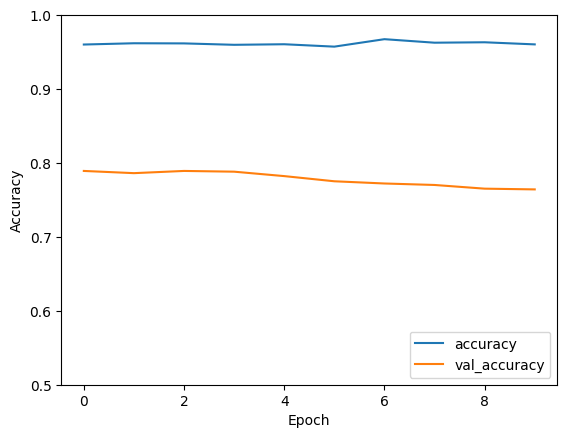

In [23]:
if continue_training:
    mh.model_plot_accuracy(history_continued)

 > Evaluating model Resnet50_tert_brightness_channelshift_dropout02_adam_lr_scheduler:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 39s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.9335055480685597
 > Micro AUC: 0.9250680276174199


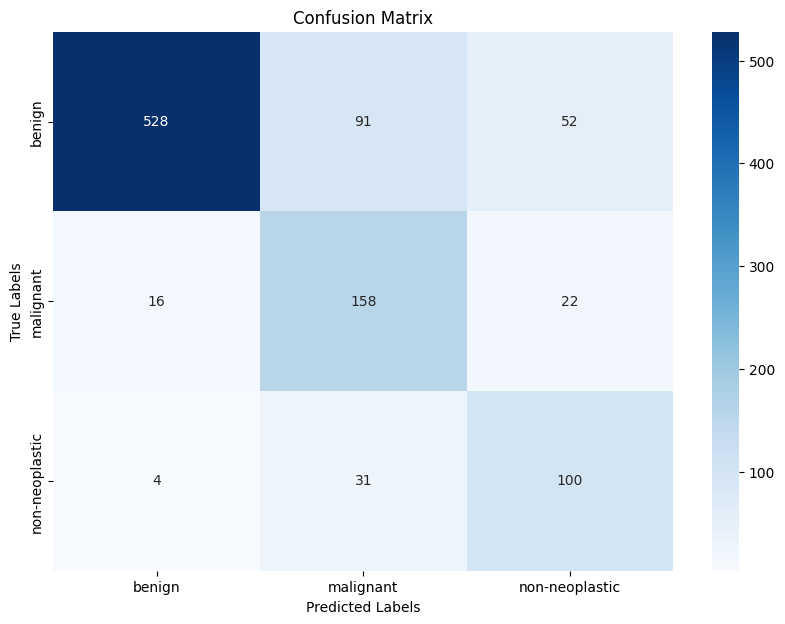



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       671
           1       0.56      0.81      0.66       196
           2       0.57      0.74      0.65       135

    accuracy                           0.78      1002
   macro avg       0.70      0.78      0.73      1002
weighted avg       0.83      0.78      0.80      1002

 > Evaluating model on test set...
32/32 [==============================] - 44s 1s/step - loss: 0.9834 - accuracy: 0.7844 - f1_score: 0.7826
loss: 0.9833694696426392
accuracy: 0.7844311594963074
f1_score: 0.7826016545295715
 > Done.


In [24]:
if continue_training:
    mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

In [ ]:
if continue_training:
    from datetime import datetime
    timestamp = datetime.now()
    model_path = f"../models/model_{timestamp}.h5"
    model.save(model_path)